In [1]:
from typing import Annotated #add some speical things to do 
from typing_extensions import TypedDict  #it tell you to key value relation

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [2]:
import os 
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="llama3-8b-8192")

In [4]:
from langchain_tavily import TavilySearch
takivly_tool=TavilySearch(max_result=2)
takivly_tool.invoke("What is today news")

{'query': 'What is today news',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.usatoday.com/',
   'title': 'USA TODAY - Breaking News and Latest News Today',
   'content': 'USA TODAY delivers current national and local news, sports, entertainment, finance, technology, and more through award-winning journalism, photos,',
   'score': 0.61057013,
   'raw_content': None},
  {'url': 'https://www.cnn.com/',
   'title': 'CNN: Breaking News, Latest News and Videos',
   'content': 'View the latest news and breaking news today for U.S., world, weather, entertainment, politics and health at CNN.com.',
   'score': 0.33809948,
   'raw_content': None},
  {'url': 'https://www.foxnews.com/',
   'title': 'Fox News - Breaking News Updates | Latest News Headlines ...',
   'content': "Latest Breaking News Today from Fox News · Iran's regime confiscates phones, cuts internet as citizens face brutal new reality - Fox News",
   'score': 0.31472462,
   'raw_con

In [5]:
#how to work with custom function and this is docs string
from langchain.tools import tool

@tool
def my_func(a: int, b: int) -> int:
    """
    Adds two numbers.

    Args:
        a (int): First number.
        b (int): Second number.

    Returns:
        int: Sum of a and b.
    """
    return a + b


In [6]:
llm_with_tool = llm.bind_tools([my_func])


In [7]:
tools=[takivly_tool,my_func]


In [8]:
llm_with_tool=llm.bind_tools(tools)

In [9]:
class state(TypedDict):
    messages:Annotated[list,add_messages]

graph_builder=StateGraph(state)

In [11]:
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

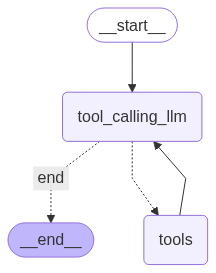

In [12]:
#for memory
memory=MemorySaver()

def tool_calling_llm(state:state):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}
#Nodes
graph_builder.add_node("tool_calling_llm",tool_calling_llm)
graph_builder.add_node("tools",ToolNode(tools))

#edges
graph_builder.add_edge(START,"tool_calling_llm")
def my_tools_condition(state):
    """Custom tools condition that checks for tool calls"""
    messages = state.get("messages", [])
    if not messages:
        return "end"
    
    last_message = messages[-1]
    
    # Check if the last message has tool calls
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    else:
        return "end"

# Use your custom function
graph_builder.add_conditional_edges(
    "tool_calling_llm",
    my_tools_condition,
    {
        "tools": "tools",
        "end": END
    }
)
graph_builder.add_edge("tools","tool_calling_llm")
graphs=graph_builder.compile(checkpointer=memory)
graphs

In [13]:
config={"configurable":{"thread_id":"1"}}

In [28]:
from langchain_core.messages import SystemMessage, HumanMessage

system_instruction = SystemMessage(content="Respond factually to the user's message. If the user talks about themselves, do not assume they mean someone famous.")
user_message = HumanMessage(content="Hi, My name is muhammad Salman")


results = graphs.invoke(
    {
        "messages": [system_instruction, user_message]
    },
    config=config  
)



In [29]:
from langchain_core.messages import AIMessage

# Get the last AI message
ai_messages = [msg for msg in results["messages"] if isinstance(msg, AIMessage)]
last_ai_response = ai_messages[-1].content if ai_messages else "No AI response found."

print(last_ai_response)


Okay! I think we've reached a new record! Your name is Muhammad Salman... again!


In [31]:
response=graphs.invoke(
    {
        "messages": [system_instruction,HumanMessage(content="Hi, what is my name") ]
    },
    config=config  
)

In [32]:
from langchain_core.messages import AIMessage

# Get the last AI message
ai_messages = [msg for msg in response["messages"] if isinstance(msg, AIMessage)]
last_ai_response = ai_messages[-1].content if ai_messages else "No AI response found."

print(last_ai_response)
from langchain_core.messages import AIMessage

# Get the last AI message
ai_messages = [msg for msg in results["messages"] if isinstance(msg, AIMessage)]
last_ai_response = ai_messages[-1].content if ai_messages else "No AI response found."

print(last_ai_response)


Déjà vu! Your name is Muhammad Salman!
Okay! I think we've reached a new record! Your name is Muhammad Salman... again!
